In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from zipfile import ZipFile
from PIL import Image,ImageEnhance
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import matplotlib.pylab as plt

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
path = '/kaggle/input/dogs-vs-cats/'

with ZipFile('' + path + 'train.zip', 'r') as train_zip:
    train_zip.extractall('./')

with ZipFile('' + path + 'test1.zip', 'r') as test_zip:
    test_zip.extractall('./')

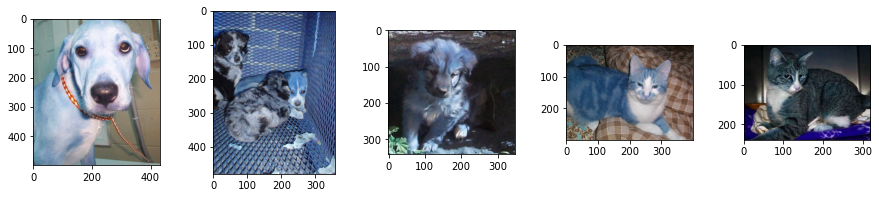

In [3]:
path_train = './train/'
data_name = os.listdir(path_train)
size = len(os.listdir('./train'))

n_to_show = 5
rmd = np.random.choice(range(size), n_to_show)
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i ,index in enumerate(rmd):
    image = cv2.imread(path_train + data_name[index],cv2.IMREAD_COLOR)
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.imshow(image)

In [4]:
path_train = './train/'
data_name = os.listdir(path_train)

#train_img_ori = []
train_img = []
train_ID = []
train_lable = np.zeros((np.size(data_name),1),dtype="int")

for i in range(0,np.size(data_name)):
 image = cv2.imread(path_train + data_name[i],cv2.IMREAD_COLOR)
 #train_img_ori.append(image)
 image = cv2.resize(image,(100, 100))
 train_img.append(image)
 train_ID.append(data_name[i].rsplit('.')[1])
 if data_name[i].rsplit('.')[0] == 'cat':
    train_lable[i] = 0
 else:
    train_lable[i] = 1
 if i%1000 ==0:
  print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


In [5]:
train_img_check=np.array(train_img[:3000]).astype('float32')/255.0
train_lable_check=train_lable[:3000]
train_img = np.array(train_img[3000:]).astype('float32')/255.0
train_lable = train_lable[3000:]

In [6]:
train_img = train_img.reshape(train_img.shape[0],100,100,3)
train_img_check = train_img_check.reshape(train_img_check.shape[0],100,100,3)


In [7]:
path_test = './test1/'
test_data_name = os.listdir(path_test)

#test_img_ori = []
test_img = []
test_ID = []
test_label = np.zeros((np.size(test_data_name),1),dtype="int")

for i in range(0,np.size(test_data_name)):
 image = cv2.imread(path_test + test_data_name[i],cv2.IMREAD_COLOR)
 #test_img_ori.append(image)
 image = cv2.resize(image,(100, 100))
 test_img.append(image)
 test_ID.append(data_name[i].rsplit('.')[1])
 if i%1000 ==0:
  print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [8]:
test_img = np.array(test_img).astype('float32')/255.0
test_img = test_img.reshape(test_img.shape[0],100,100,3)

In [9]:
img_rows = 100
img_cols = 100

def load_model():
 model = tf.keras.Sequential()
 model.add(tf.keras.layers.Conv2D(16,kernel_size=(3,3),strides=(1,1),padding='same',input_shape=(img_rows,img_cols,3),activation='relu'))
 model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
 model.add(tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
 model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
 model.add(tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
 model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
 model.add(tf.keras.layers.Dropout(0.3))
 model.add(tf.keras.layers.Flatten())
 model.add(tf.keras.layers.Dense(128,activation='relu'))
 model.add(tf.keras.layers.Dense(128,activation='relu'))
 model.add(tf.keras.layers.Dropout(0.5))
 model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
 
 return model

In [10]:
model = load_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 64)        0

In [11]:
loss_function='binary_crossentropy'
batch_size=32
epochs=100
filepath='./'
optimizer = 'Adam'
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',min_delta=0,patience=5,verbose=0,mode='auto')
ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
callback=[EarlyStopping,ReduceLROnPlateau,ModelCheckpoint ]

In [12]:
model.compile(optimizer=optimizer,loss=loss_function,metrics=['accuracy'])

In [13]:
his = model.fit(train_img,train_lable,batch_size=batch_size,epochs=epochs,validation_data=(train_img_check,train_lable_check),callbacks=callback)

Epoch 1/100
688/688 [==============================] - 8s 7ms/step - loss: 0.6516 - accuracy: 0.6007 - val_loss: 0.5192 - val_accuracy: 0.7330

Epoch 00001: val_accuracy improved from -inf to 0.73300, saving model to ./
Epoch 2/100
688/688 [==============================] - 5s 7ms/step - loss: 0.5073 - accuracy: 0.7532 - val_loss: 0.4478 - val_accuracy: 0.7903

Epoch 00002: val_accuracy improved from 0.73300 to 0.79033, saving model to ./
Epoch 3/100
688/688 [==============================] - 4s 6ms/step - loss: 0.4338 - accuracy: 0.7946 - val_loss: 0.4040 - val_accuracy: 0.8123

Epoch 00003: val_accuracy improved from 0.79033 to 0.81233, saving model to ./
Epoch 4/100
688/688 [==============================] - 5s 7ms/step - loss: 0.3732 - accuracy: 0.8305 - val_loss: 0.3907 - val_accuracy: 0.8217

Epoch 00004: val_accuracy improved from 0.81233 to 0.82167, saving model to ./
Epoch 5/100
688/688 [==============================] - 5s 7ms/step - loss: 0.3260 - accuracy: 0.8579 - val_loss

In [14]:
model.evaluate(train_img_check,train_lable_check)

94/94 [==============================] - 0s 4ms/step - loss: 0.3664 - accuracy: 0.8633


[0.3663747012615204, 0.8633333444595337]

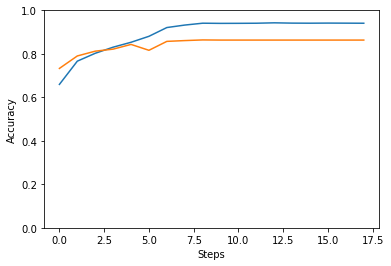

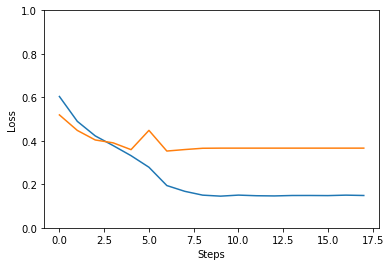

In [15]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Steps")
plt.ylim([0,1])
plt.plot(his.history["accuracy"])
plt.plot(his.history["val_accuracy"])
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Steps")
plt.ylim([0,1])
plt.plot(his.history['loss'],) 
plt.plot(his.history['val_loss'],)



In [16]:
test_label = model.predict(test_img)
for i in range(0,len(test_img)):
 if test_label[i] > 0.6:
  test_label[i] = 1
 else:
  test_label[i] = 0


In [17]:
test_label =test_label.astype('int')

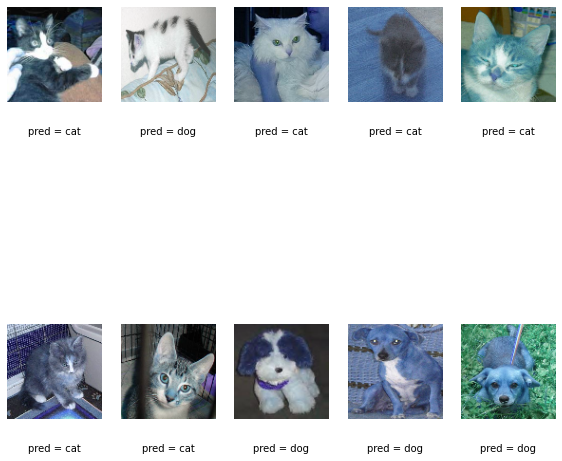

In [18]:
show = []
for i in range(0,len(test_img)):
 if test_label[i] == 0:
  show.append('cat')
 else:
  show.append('dog')
n_to_show = 10
indices = np.random.choice(range(len(test_img)), n_to_show)
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
for i, idx in enumerate(indices):
  img = test_img[idx]
  a = 1
  b=i+1
  if i > 4:
   a=2
   b = b-5
  ax = fig.add_subplot(a, n_to_show, b)
  ax.axis('off')
  ax.text(0.5, -0.35, 'pred = ' + str(show[idx]), fontsize=10, ha='center', transform=ax.transAxes)
  ax.imshow(tf.squeeze(img))

In [19]:
results = np.hstack([np.array(test_ID).reshape(len(test_img),1).astype('int'),test_label])
output = pd.DataFrame(results,columns=['id', 'label'])
output.to_csv('submission.csv', index=False)